In [ ]:
"""Importing Libraries"""
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Plotly for interactive charts
!pip install keras-tuner shap --quiet
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import norm, ttest_rel
import keras_tuner as kt
import shap
import plotly.express as px
import plotly.graph_objs as go

In [ ]:
try:
    import gdown
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "--upgrade", "gdown"])
    import gdown

file_id = "16roDpQxTS2s-X7Lxg8wwEaoZ89k16I6V"
output_path = os.path.join("data", "all_stocks_5yr.csv")
os.makedirs("data", exist_ok=True)

if not os.path.exists(output_path):
    print("⬇️ Downloading dataset...")
    gdown.download(id=file_id, output=output_path, quiet=False)
else:
    print("✅ Dataset already exists.")

✅ Dataset already exists.


In [ ]:
"""Data Cleaning process"""

data = pd.read_csv(output_path)
data['date'] = pd.to_datetime(data['date'])
data.sort_values(['Name', 'date'], inplace=True)
data.reset_index(drop=True, inplace=True)

print(data.shape)
print(data.columns)
print(data['Name'].nunique())  # Number of unique stocks
data.isnull().sum()

df = pd.DataFrame(data)

print("Original DataFrame:")
print(df)
stock_names=df['Name'].unique()
print(stock_names)


(619040, 7)
Index(['date', 'open', 'high', 'low', 'close', 'volume', 'Name'], dtype='object')
505
Original DataFrame:
             date   open   high    low  close   volume Name
0      2013-02-08  45.07  45.35  45.00  45.08  1824755    A
1      2013-02-11  45.17  45.18  44.45  44.60  2915405    A
2      2013-02-12  44.81  44.95  44.50  44.62  2373731    A
3      2013-02-13  44.81  45.24  44.68  44.75  2052338    A
4      2013-02-14  44.72  44.78  44.36  44.58  3826245    A
...           ...    ...    ...    ...    ...      ...  ...
619035 2018-02-01  76.84  78.27  76.69  77.82  2982259  ZTS
619036 2018-02-02  77.53  78.12  76.73  76.78  2595187  ZTS
619037 2018-02-05  76.64  76.92  73.18  73.83  2962031  ZTS
619038 2018-02-06  72.74  74.56  72.13  73.27  4924323  ZTS
619039 2018-02-07  72.70  75.00  72.69  73.86  4534912  ZTS

[619040 rows x 7 columns]
['A' 'AAL' 'AAP' 'AAPL' 'ABBV' 'ABC' 'ABT' 'ACN' 'ADBE' 'ADI' 'ADM' 'ADP'
 'ADS' 'ADSK' 'AEE' 'AEP' 'AES' 'AET' 'AFL' 'AGN' 'AIG' 'AIV'

In [ ]:
# Fill missing values with the mean of specific columns: 'open', 'high', and 'low'
columns_to_fill = ['open', 'high', 'low']
df[columns_to_fill] = df[columns_to_fill].fillna(df[columns_to_fill].mean())

print("\nDataFrame after filling missing values with the average in specified columns:")
print(df)

df.isnull().sum()


DataFrame after filling missing values with the average in specified columns:
             date   open   high    low  close   volume Name
0      2013-02-08  45.07  45.35  45.00  45.08  1824755    A
1      2013-02-11  45.17  45.18  44.45  44.60  2915405    A
2      2013-02-12  44.81  44.95  44.50  44.62  2373731    A
3      2013-02-13  44.81  45.24  44.68  44.75  2052338    A
4      2013-02-14  44.72  44.78  44.36  44.58  3826245    A
...           ...    ...    ...    ...    ...      ...  ...
619035 2018-02-01  76.84  78.27  76.69  77.82  2982259  ZTS
619036 2018-02-02  77.53  78.12  76.73  76.78  2595187  ZTS
619037 2018-02-05  76.64  76.92  73.18  73.83  2962031  ZTS
619038 2018-02-06  72.74  74.56  72.13  73.27  4924323  ZTS
619039 2018-02-07  72.70  75.00  72.69  73.86  4534912  ZTS

[619040 rows x 7 columns]


,0
date,0
open,0
high,0
low,0
close,0
volume,0
Name,0


In [ ]:
"""Exploratory Data Analysis"""

'Exploratory Data Analysis'

In [ ]:
# Check Summary Statistics
df.describe()


,date,open,high,low,close,volume
count,619040,619040.000000,619040.000000,619040.000000,619040.000000,6.190400e+05
mean,2015-08-18 00:48:23.494443264,83.023334,83.778311,82.256096,83.043763,4.321823e+06
min,2013-02-08 00:00:00,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,2014-05-20 00:00:00,40.220000,40.620000,39.830000,40.245000,1.070320e+06
50%,2015-08-21 00:00:00,62.590000,63.150000,62.020000,62.620000,2.082094e+06
75%,2016-11-15 00:00:00,94.370000,95.180000,93.535375,94.410000,4.284509e+06
max,2018-02-07 00:00:00,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08
std,NaN,97.377904,98.206884,96.506797,97.389748,8.693610e+06


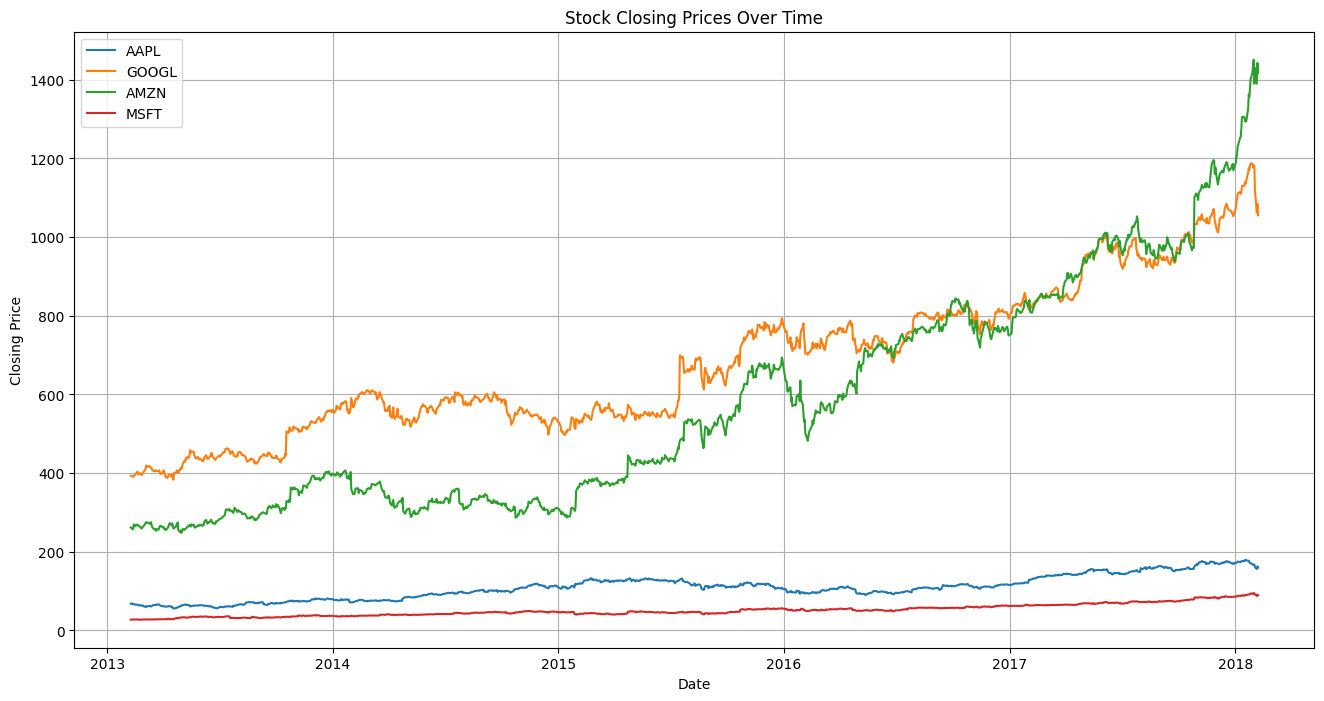

In [ ]:
# Plot closing prices of major stocks
companies = ['AAPL', 'GOOGL', 'AMZN', 'MSFT']

plt.figure(figsize=(16, 8))
for company in companies:
    stock = df[df['Name'] == company]
    plt.plot(stock['date'], stock['close'], label=company)

plt.legend()
plt.title('Stock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid()
plt.show()

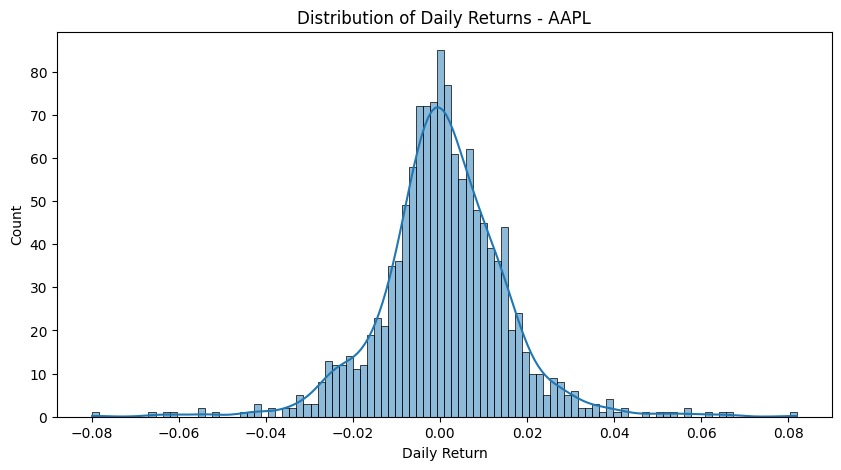

In [ ]:
# Distribution of Daily Returns for a Stock
stock = df[df['Name'] == 'AAPL'].copy()
stock['daily_return'] = stock['close'].pct_change()

plt.figure(figsize=(10, 5))
sns.histplot(stock['daily_return'].dropna(), bins=100, kde=True)
plt.title('Distribution of Daily Returns - AAPL')
plt.xlabel('Daily Return')
plt.show()

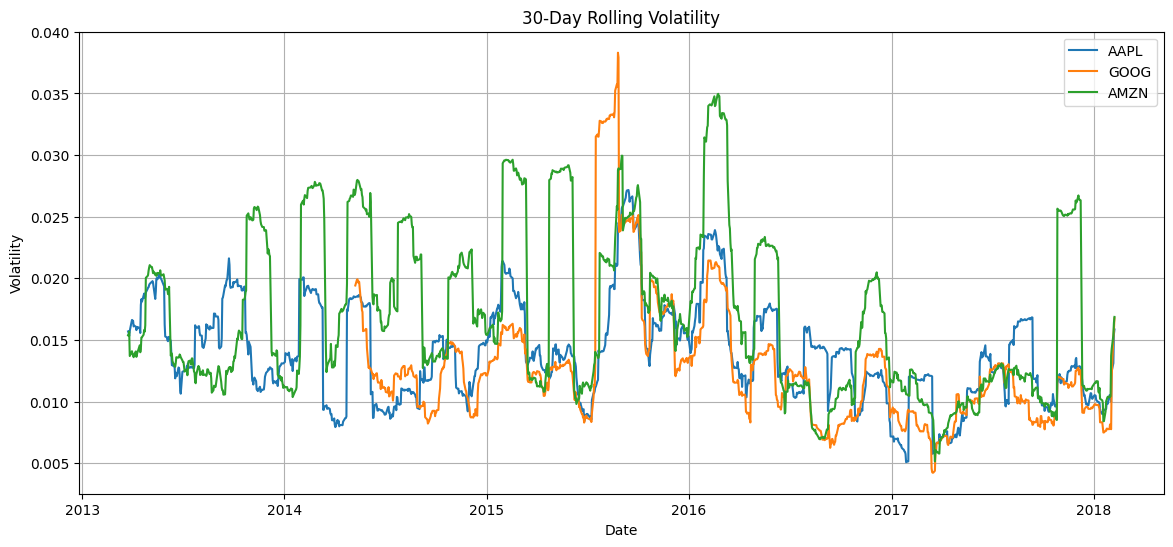

In [ ]:
# Volatility Comparison (Rolling Standard Deviation)
plt.figure(figsize=(14, 6))
for company in ['AAPL', 'GOOG', 'AMZN']:
    subset = df[df['Name'] == company].copy()
    subset.set_index('date', inplace=True)
    subset['rolling_vol'] = subset['close'].pct_change().rolling(window=30).std()
    plt.plot(subset['rolling_vol'], label=company)

plt.title('30-Day Rolling Volatility')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.legend()
plt.grid()
plt.show()

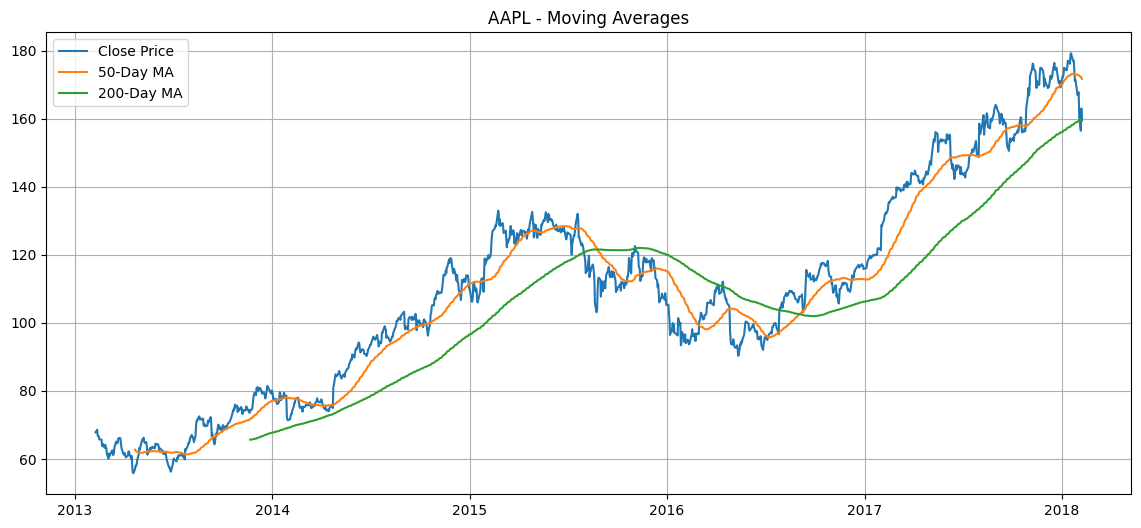

In [ ]:
# Moving Averages
apple = df[df['Name'] == 'AAPL'].copy()
apple.set_index('date', inplace=True)
apple['MA50'] = apple['close'].rolling(window=50).mean()
apple['MA200'] = apple['close'].rolling(window=200).mean()

plt.figure(figsize=(14, 6))
plt.plot(apple['close'], label='Close Price')
plt.plot(apple['MA50'], label='50-Day MA')
plt.plot(apple['MA200'], label='200-Day MA')
plt.title('AAPL - Moving Averages')
plt.legend()
plt.grid()
plt.show()

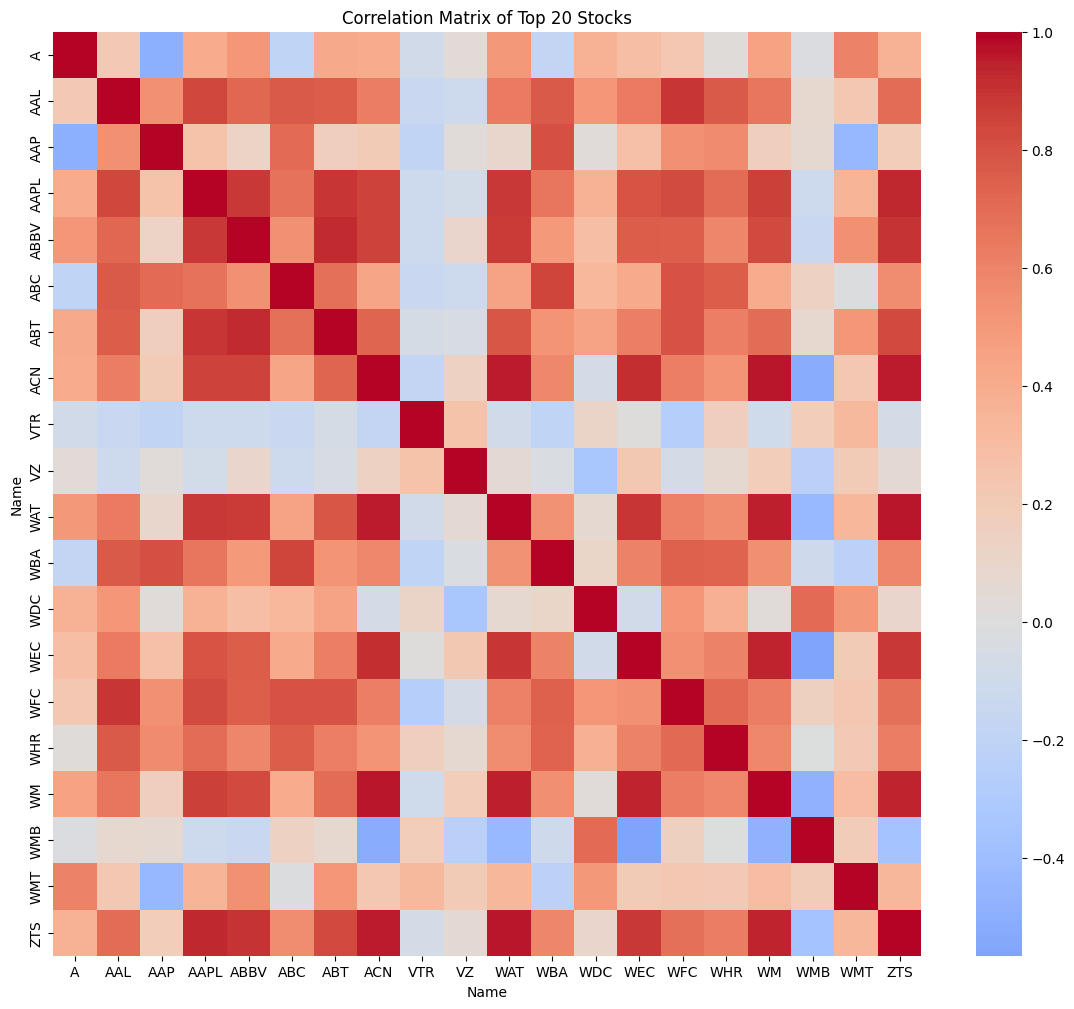

In [ ]:
# Correlation Matrix of Closing Prices (Top 20 Stocks)
top20 = df['Name'].value_counts().head(20).index.tolist()
filtered_df = df[df['Name'].isin(top20)]
pivot = filtered_df.pivot(index='date', columns='Name', values='close')
correlation_matrix = pivot.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Top 20 Stocks")
plt.show()

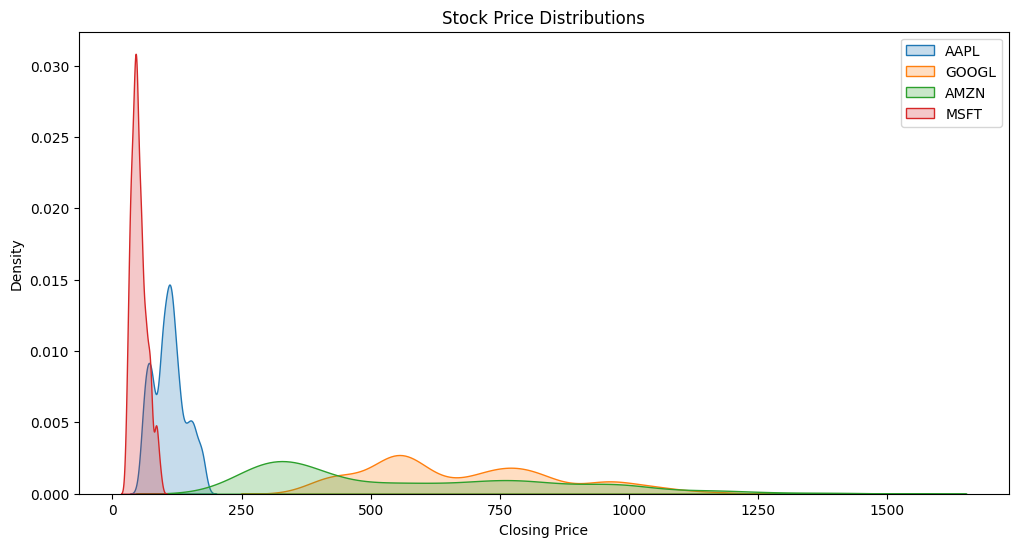

In [ ]:
# Stock Price Distribution Using KDE (Kernel Density Estimation)
plt.figure(figsize=(12, 6))
for stock in ['AAPL', 'GOOGL', 'AMZN', 'MSFT']:
    sns.kdeplot(df[df['Name'] == stock]['close'], label=stock, fill=True)

plt.title("Stock Price Distributions")
plt.xlabel("Closing Price")
plt.legend()
plt.show()


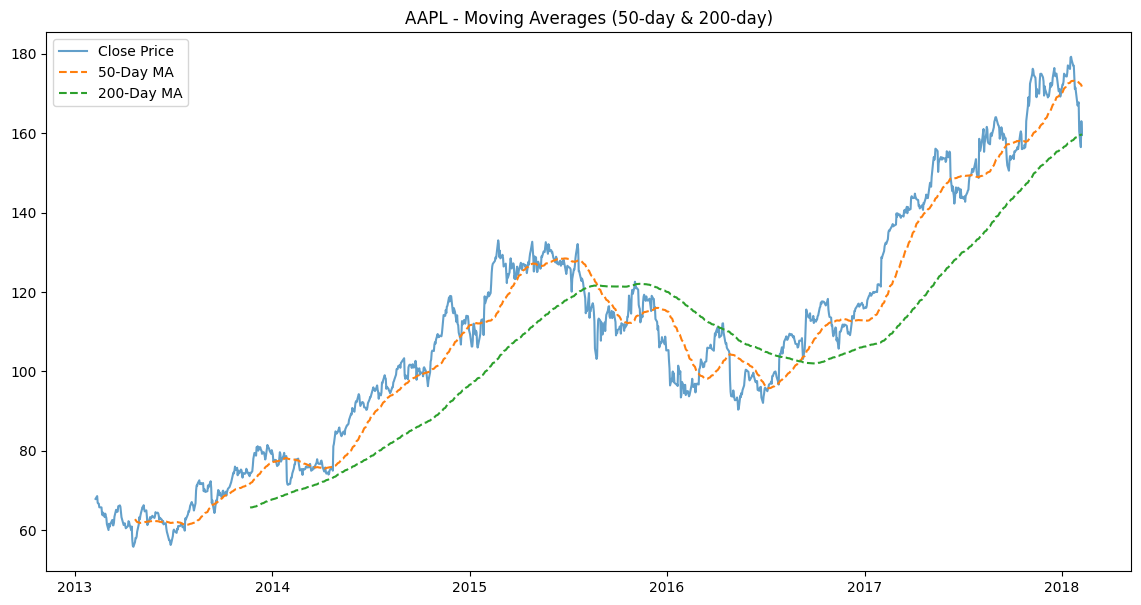

In [ ]:
# Rolling Mean (Moving Average) Analysis
apple = df[df['Name'] == 'AAPL'].copy()
apple['MA50'] = apple['close'].rolling(window=50).mean()
apple['MA200'] = apple['close'].rolling(window=200).mean()
plt.figure(figsize=(14, 7))
plt.plot(apple['date'], apple['close'], label="Close Price", alpha=0.7)
plt.plot(apple['date'], apple['MA50'], label="50-Day MA", linestyle='dashed')
plt.plot(apple['date'], apple['MA200'], label="200-Day MA", linestyle='dashed')

plt.legend()
plt.title("AAPL - Moving Averages (50-day & 200-day)")
plt.show()


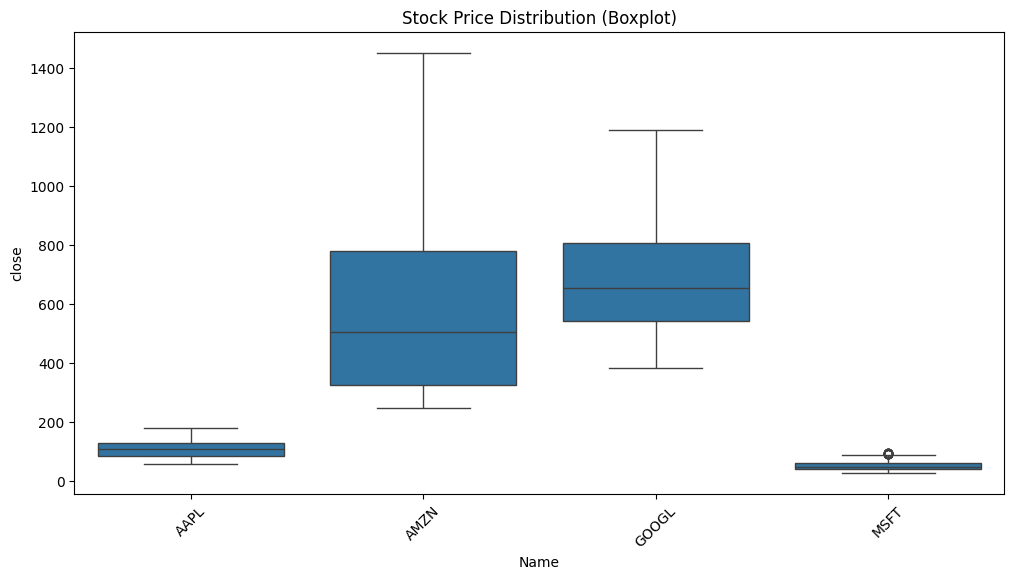

In [ ]:
# Boxplot for Stock Price Distribution
plt.figure(figsize=(12, 6))
sns.boxplot(x='Name', y='close', data=df[df['Name'].isin(['AAPL', 'GOOGL', 'AMZN', 'MSFT'])])
plt.xticks(rotation=45)
plt.title('Stock Price Distribution (Boxplot)')
plt.show()

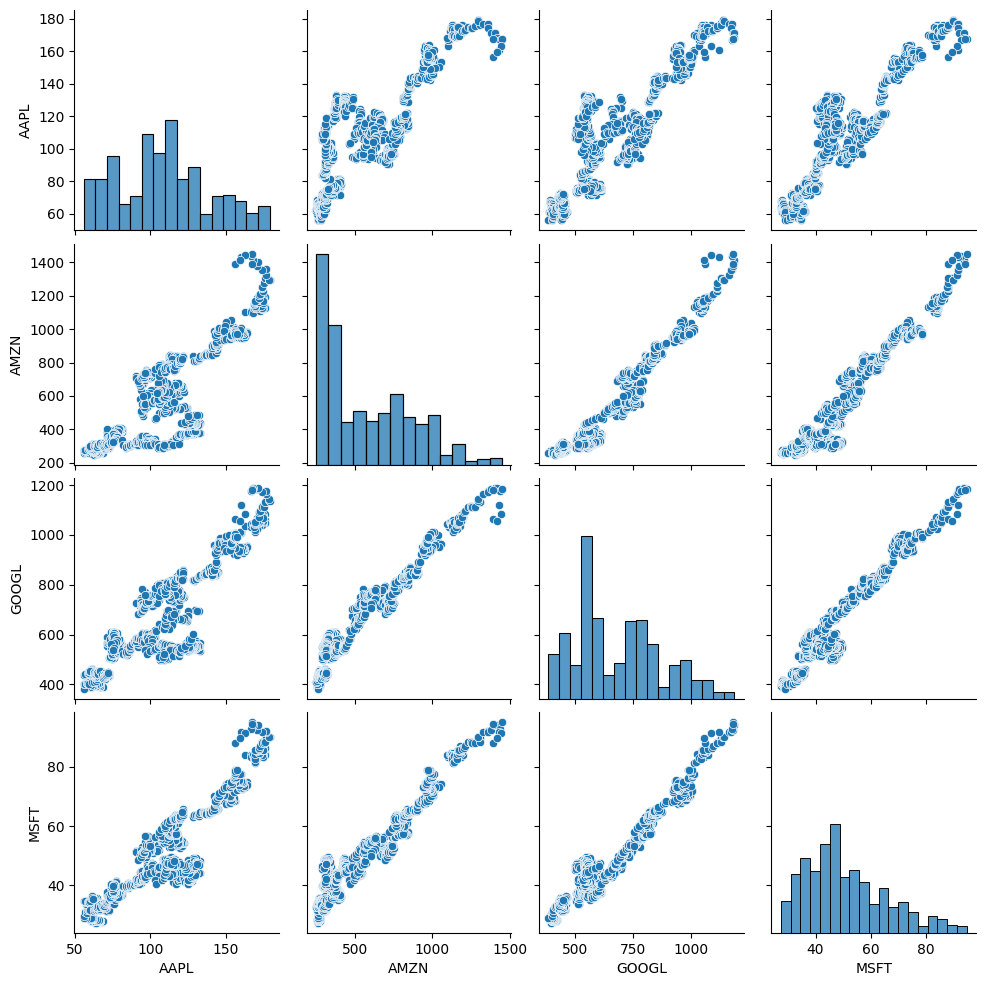

In [ ]:
# Pairplot for Selected Stocks
selected_stocks = df[df['Name'].isin(['AAPL', 'GOOGL', 'AMZN', 'MSFT'])]
pivoted = selected_stocks.pivot(index='date', columns='Name', values='close')
sns.pairplot(pivoted)
plt.show()

In [ ]:
# Candlestick Chart for AAPL
fig = go.Figure(data=[go.Candlestick(x=apple['date'],
                open=apple['open'],
                high=apple['high'],
                low=apple['low'],
                close=apple['close'])])
fig.update_layout(title='AAPL Candlestick Chart', xaxis_rangeslider_visible=False)
fig.show()

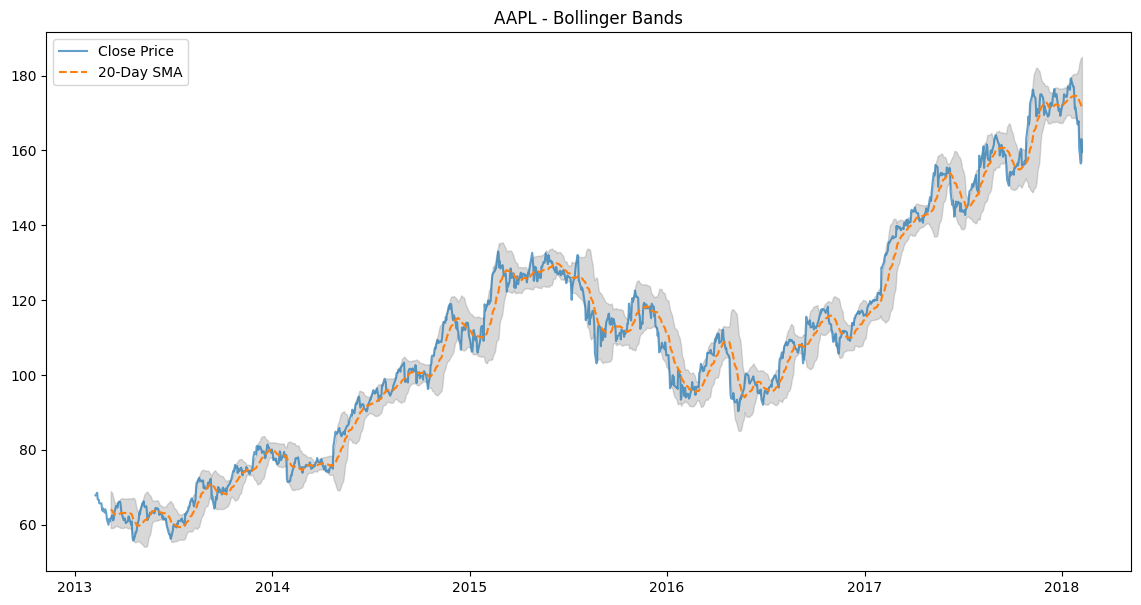

In [ ]:
# Bollinger Bands for AAPL
apple['SMA20'] = apple['close'].rolling(window=20).mean()
apple['UpperBand'] = apple['SMA20'] + 2 * apple['close'].rolling(window=20).std()
apple['LowerBand'] = apple['SMA20'] - 2 * apple['close'].rolling(window=20).std()

plt.figure(figsize=(14, 7))
plt.plot(apple['date'], apple['close'], label='Close Price', alpha=0.7)
plt.plot(apple['date'], apple['SMA20'], label='20-Day SMA', linestyle='dashed')
plt.fill_between(apple['date'], apple['UpperBand'], apple['LowerBand'], color='gray', alpha=0.3)

plt.legend()
plt.title('AAPL - Bollinger Bands')
plt.show()

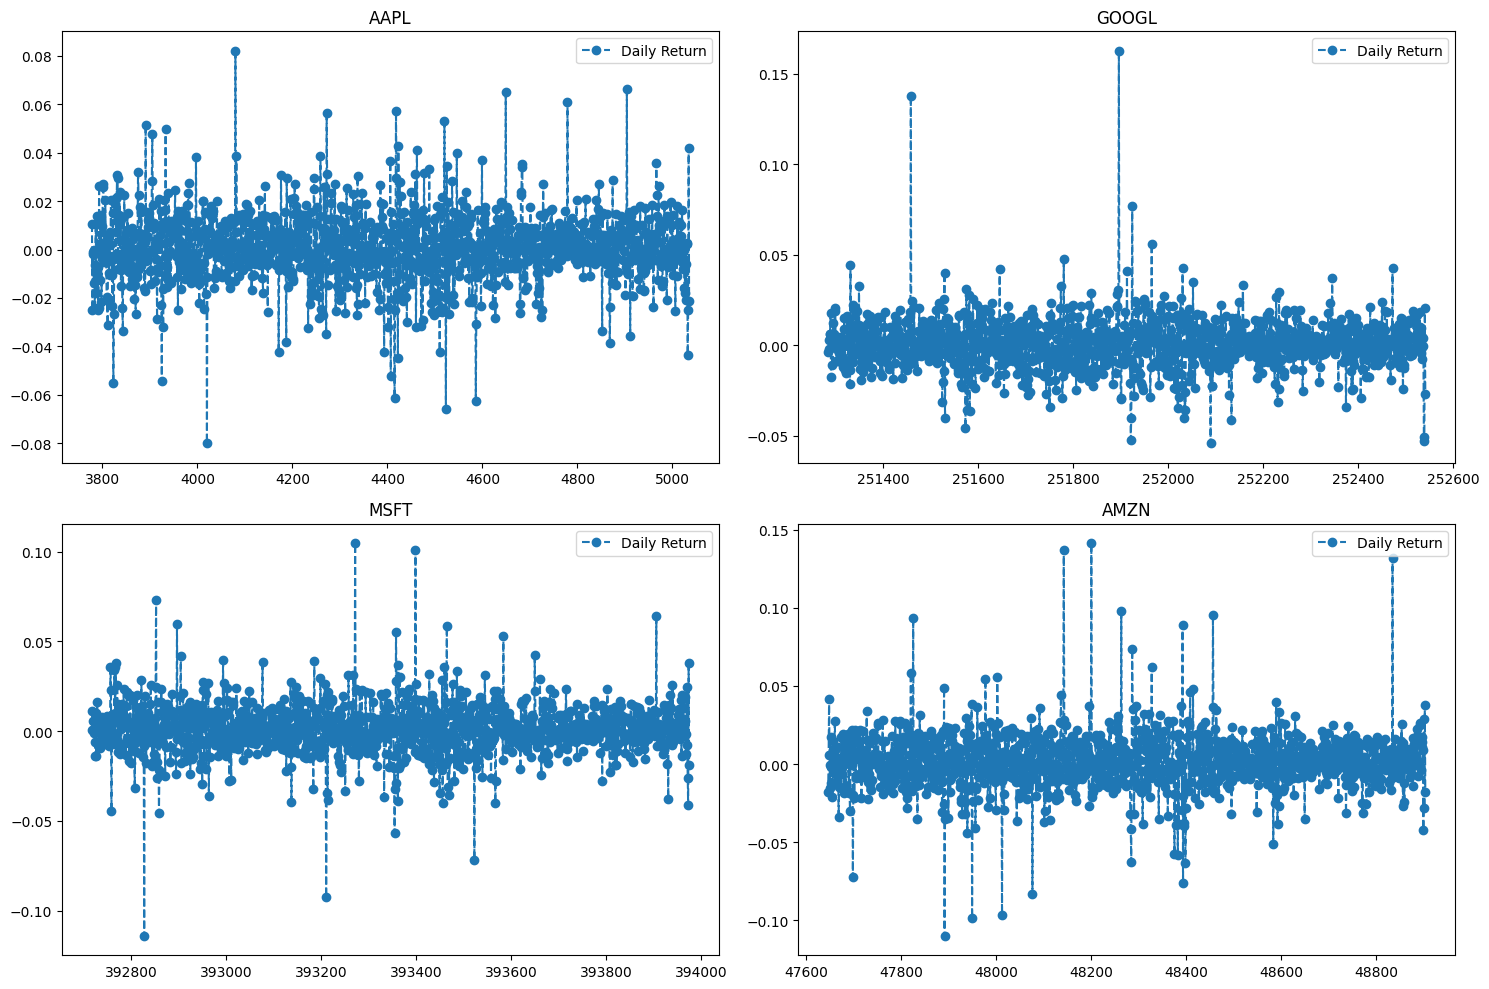

In [ ]:
# Daily Return Percentage for Selected Stocks
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

company_list = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']
for i, stock in enumerate(company_list):
    df_stock = df[df['Name'] == stock].copy()
    df_stock['Daily Return'] = df_stock['close'].pct_change()

    row, col = divmod(i, 2)
    df_stock['Daily Return'].plot(ax=axes[row, col], legend=True, linestyle='--', marker='o')
    axes[row, col].set_title(stock)

fig.tight_layout()
plt.show()

In [ ]:
# Increase figure size
plt.figure(figsize=(15, 8))
# Convert columns to numeric, forcing errors to NaN
df_numeric = df.apply(pd.to_numeric, errors='coerce')

# Compute correlation, filling NaN values with 0
correlation_matrix = df_numeric.corr().fillna(0)

<Figure size 1500x800 with 0 Axes>

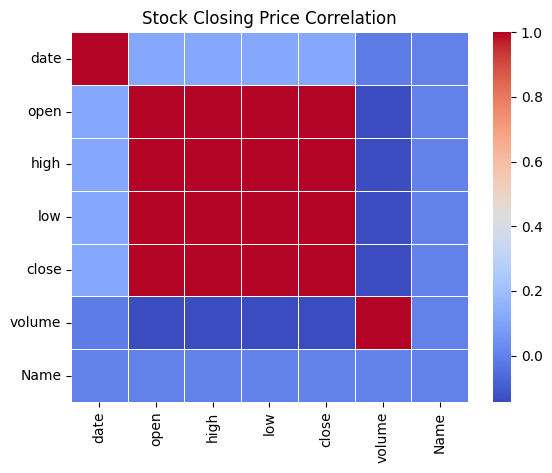

In [ ]:
# Create heatmap with optimized settings
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)

plt.title("Stock Closing Price Correlation")
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.yticks(rotation=0)
plt.show()


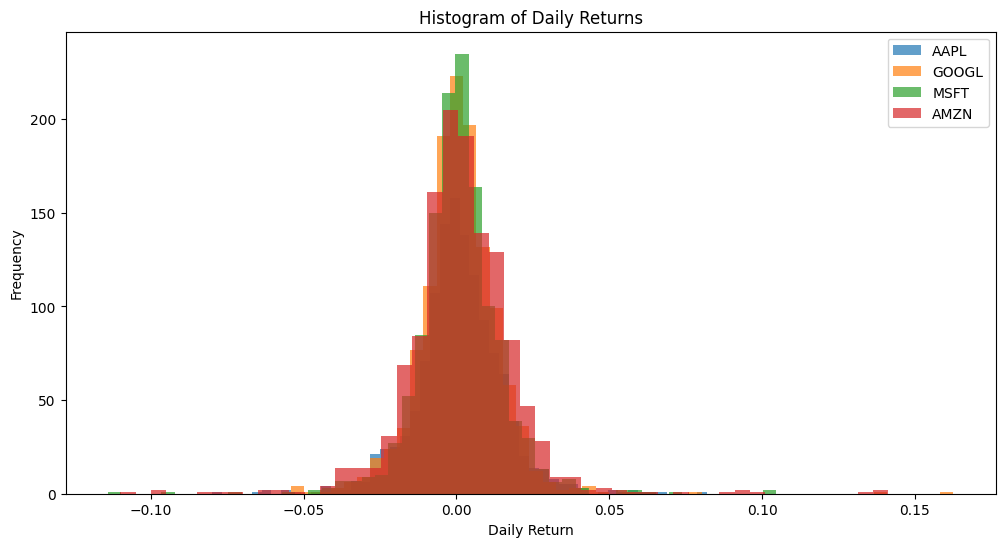

In [ ]:
plt.figure(figsize=(12, 6))

for stock in company_list:
    daily_returns = df[df['Name'] == stock]['close'].pct_change().dropna()
    plt.hist(daily_returns, bins=50, alpha=0.7, label=stock)

plt.legend()
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.title("Histogram of Daily Returns")
plt.show()



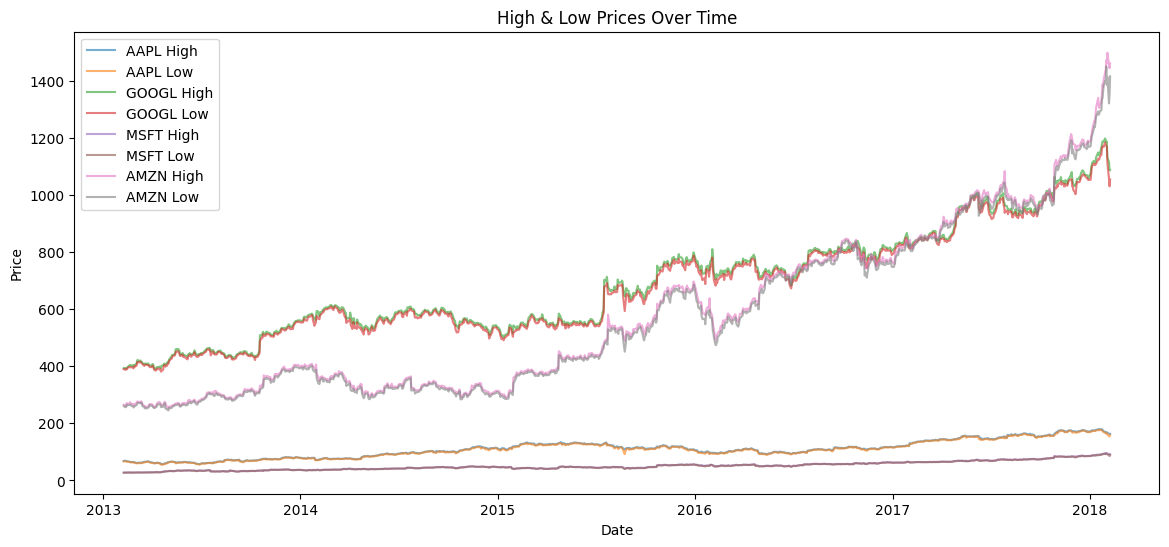

In [ ]:
plt.figure(figsize=(14, 6))

for stock in company_list:
    subset = df[df['Name'] == stock]
    plt.plot(subset['date'], subset['high'], label=f'{stock} High', alpha=0.6)
    plt.plot(subset['date'], subset['low'], label=f'{stock} Low', alpha=0.6)

plt.legend()
plt.title('High & Low Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

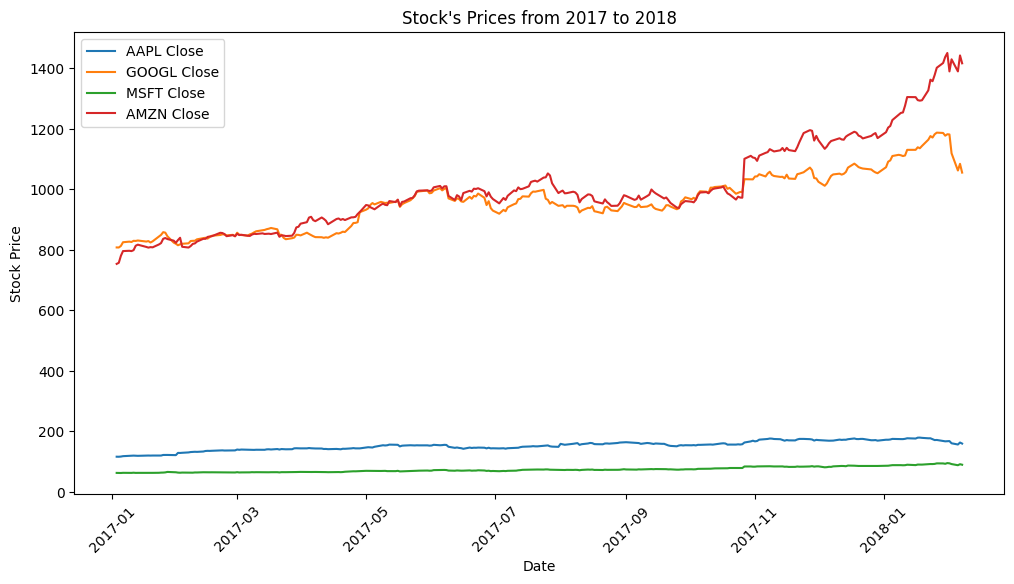

In [ ]:
df_filtered = df[(df['date'] >= '2017-01-01') & (df['date'] <= '2018-12-31')]

plt.figure(figsize=(12, 6))
for stock in company_list:
    subset = df_filtered[df_filtered['Name'] == stock]
    plt.plot(subset['date'], subset['close'], label=f'{stock} Close')

plt.legend()
plt.title("Stock's Prices from 2017 to 2018")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.xticks(rotation=45)
plt.show()

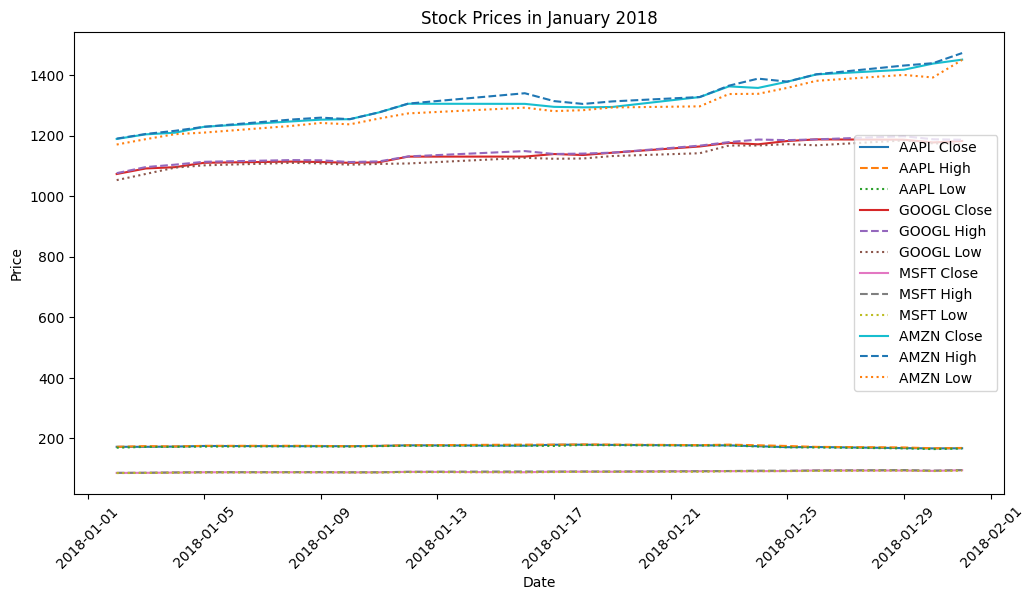

In [ ]:
df_jan2018 = df[(df['date'] >= '2018-01-01') & (df['date'] <= '2018-01-31')]

plt.figure(figsize=(12, 6))
for stock in company_list:
    subset = df_jan2018[df_jan2018['Name'] == stock]
    plt.plot(subset['date'], subset['close'], label=f'{stock} Close', linestyle='solid')
    plt.plot(subset['date'], subset['high'], label=f'{stock} High', linestyle='dashed')
    plt.plot(subset['date'], subset['low'], label=f'{stock} Low', linestyle='dotted')

plt.legend()
plt.title("Stock Prices in January 2018")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.show()

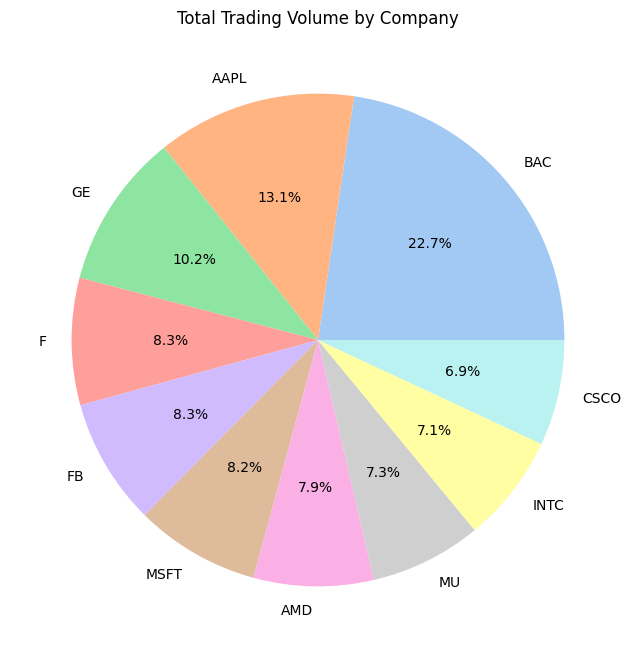

In [ ]:
df_volume = df.groupby('Name')['volume'].sum().nlargest(10)

plt.figure(figsize=(8, 8))
plt.pie(df_volume, labels=df_volume.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Total Trading Volume by Company')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# Example placeholder for compute_rsi
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    rs = avg_gain / (avg_loss + 1e-8)
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [ ]:
# Example placeholder for create_sequences
def create_sequences(data, time_steps=50):
    X = []
    y = []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps, 0])  # Assuming 'close' is at index 0
    return np.array(X), np.array(y).reshape(-1, 1)

In [ ]:
# Example DataFrame setup (simulate some data):
# Replace this with your actual data loading
np.random.seed(42)
num_samples = 1000
stock_names = ['AAPL', 'GOOG']
data_records = []

for name in stock_names:
    close_prices = np.cumsum(np.random.randn(num_samples)) + 100
    for i in range(num_samples):
        data_records.append({
            'Name': name,
            'close': close_prices[i],
            'date': pd.Timestamp('2020-01-01') + pd.Timedelta(days=i)
        })

data = pd.DataFrame(data_records)

In [ ]:
# 1. Feature Engineering
data['RSI'] = compute_rsi(data['close'])
data['MA_7'] = data['close'].rolling(7).mean()
data['MA_30'] = data['close'].rolling(30).mean()
data['Volatility'] = data['close'].rolling(7).std()
data.dropna(inplace=True)

In [ ]:
# 2. Scale entire dataset
scaler = MinMaxScaler()
scaled_features = ['close', 'MA_7', 'MA_30', 'Volatility', 'RSI']
scaled_data = scaler.fit_transform(data[scaled_features])

In [ ]:
# 3. Create sequences for the entire dataset (optional)
X_all, y_all = create_sequences(scaled_data, time_steps=50)

In [ ]:
# 4. Split into train/test for the entire dataset
split_idx = int(0.8 * len(X_all))
X_train, X_test = X_all[:split_idx], X_all[split_idx:]
y_train, y_test = y_all[:split_idx], y_all[split_idx:]

In [ ]:
# 5. Loop through each stock to evaluate
for stock in stock_names:
    # Filter data for the current stock
    stock_df = data[data['Name'] == stock].copy()
    stock_scaled = scaler.transform(stock_df[scaled_features])

    # Create sequences for this stock
    X_stock, y_stock = create_sequences(stock_scaled, time_steps=50)

    # Split stock data into train/test
    split_idx_stock = int(0.8 * len(X_stock))
    X_train_stock = X_stock[:split_idx_stock]
    y_train_stock = y_stock[:split_idx_stock]
    X_test_stock = X_stock[split_idx_stock:]
    y_test_stock = y_stock[split_idx_stock:]

    # --- Naive Persistence Baseline ---
    # Prediction is the last 'close' value in each sequence
    last_close_vals = X_test_stock[:, -1, 0]  # 'close' is at index 0
    y_pred_naive = last_close_vals.reshape(-1, 1)

    # Evaluation of naive baseline
    mse_naive = mean_squared_error(y_test_stock, y_pred_naive)
    mae_naive = mean_absolute_error(y_test_stock, y_pred_naive)

    print(f"Naive baseline for {stock}: MSE={mse_naive:.4f}, MAE={mae_naive:.4f}")

Naive baseline for AAPL: MSE=0.0001, MAE=0.0085
Naive baseline for GOOG: MSE=0.0001, MAE=0.0081


In [ ]:
  y_pred_model = np.zeros_like(y_test_stock)

In [ ]:
 # Evaluate your model
 mse_model =mean_squared_error(y_test_stock, y_pred_model)
 mae_model =mean_absolute_error(y_test_stock, y_pred_model)

print(f"Model performance for {stock}:MSE={mse_model:.4f},MAE={mae_model:.4f}")
print('-' * 50)

Model performance for GOOG:MSE=0.7354,MAE=0.8569
--------------------------------------------------


In [ ]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:
# Build models (LSTM, GRU, CNN) with hyperparameter tuning
def build_lstm_model(hp):
    model = Sequential()
    for i in range(hp.Int('num_layers', 1, 2)):
        model.add(LSTM(
            units=hp.Int(f'units_{i}', 32, 128, step=32),
            return_sequences=(i < 1),
            input_shape=(X_train.shape[1], X_train.shape[2]),
            recurrent_activation='sigmoid'  # disables CuDNNRNN for compatibility
        ))
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.2, 0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
def build_gru_model(hp):
    model = Sequential()
    for i in range(hp.Int('num_layers', 1, 2)):
        model.add(GRU(
            units=hp.Int(f'units_{i}', 32, 128, step=32),
            return_sequences=(i < 1),
            input_shape=(X_train.shape[1], X_train.shape[2]),
            recurrent_activation='sigmoid'  # disables CuDNNRNN
        ))
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.2, 0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
# Tuning with RandomSearch (faster, more control)
tuner_lstm = kt.RandomSearch(build_lstm_model, objective='val_loss', max_trials=10, executions_per_trial=1, directory='lstm_tuner', project_name='lstm')
tuner_gru = kt.RandomSearch(build_gru_model, objective='val_loss', max_trials=10, executions_per_trial=1, directory='gru_tuner', project_name='gru')

X_val = X_test[:len(X_test)//2]
y_val = y_test[:len(y_test)//2]



Reloading Tuner from lstm_tuner/lstm/tuner0.json
Reloading Tuner from gru_tuner/gru/tuner0.json


In [ ]:
tuner_lstm.search(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stop])

In [ ]:
tuner_gru.search(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stop])

Trial 10 Complete [00h 00m 06s]
val_loss: 0.00032465835101902485

Best val_loss So Far: 0.00032465835101902485
Total elapsed time: 00h 01m 37s


In [ ]:
best_lstm = tuner_lstm.get_best_models(1)[0]
best_lstm.compile(optimizer='adam', loss='mse')

best_gru = tuner_gru.get_best_models(1)[0]
best_gru.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 



In [ ]:
# CNN
model_cnn = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)
])
model_cnn.compile(optimizer='adam', loss='mse')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [ ]:
# Train models (use high epochs for better training)
EPOCHS = 30
history_lstm = best_lstm.fit(X_train, y_train, epochs=EPOCHS, batch_size=32,
                             validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)
history_gru = best_gru.fit(X_train, y_train, epochs=EPOCHS, batch_size=32,
                           validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)
history_cnn = model_cnn.fit(X_train, y_train, epochs=EPOCHS, batch_size=32,
                            validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

# Predictions
pred_lstm = best_lstm.predict(X_test)
pred_gru = best_gru.predict(X_test)
pred_cnn = model_cnn.predict(X_test)
ensemble_pred = (pred_lstm + pred_gru + pred_cnn) / 3

Epoch 1/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0058 - val_loss: 0.0026
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0027 - val_loss: 3.4948e-04
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 5/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0024 - val_loss: 0.0048
Epoch 6/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0021 - val_loss: 0.0059
Epoch 7/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 8/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 1/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0029 - val_loss: 2.6409e-04
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0021 - val_loss: 2.4239e-04
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - 

In [ ]:
# Inverse scaling predictions
def inverse_preds(preds):
    return scaler.inverse_transform(np.hstack((preds, np.zeros((len(preds), 4)))) )[:, 0]

# Actual prices
y_test_actual = inverse_preds(y_test.reshape(-1, 1))
# Predictions
pred_lstm_actual = inverse_preds(pred_lstm)
pred_gru_actual = inverse_preds(pred_gru)
pred_cnn_actual = inverse_preds(pred_cnn)
ensemble_actual = inverse_preds(ensemble_pred)

In [ ]:
# Evaluation
def print_metrics(true, pred, name):
    print(f"{name} -- RMSE: {np.sqrt(mean_squared_error(true, pred)):.2f}, MAE: {mean_absolute_error(true, pred):.2f}, R2: {r2_score(true, pred):.2f}")

print_metrics(y_test_actual, pred_lstm_actual, "LSTM")
print_metrics(y_test_actual, pred_gru_actual, "GRU")
print_metrics(y_test_actual, pred_cnn_actual, "CNN")
print_metrics(y_test_actual, ensemble_actual, "Ensemble")

LSTM -- RMSE: 1.74, MAE: 1.39, R2: 0.92
GRU -- RMSE: 1.38, MAE: 1.12, R2: 0.95
CNN -- RMSE: 1.76, MAE: 1.40, R2: 0.91
Ensemble -- RMSE: 1.53, MAE: 1.22, R2: 0.93


In [ ]:
# Confidence intervals (uncertainty)
def get_ci(preds):
    preds_array = np.array([preds for _ in range(100)])
    mean = preds_array.mean(axis=0)
    std = preds_array.std(axis=0)
    z = norm.ppf(0.975)
    lower = mean - z * std
    upper = mean + z * std
    return inverse_preds(mean), inverse_preds(lower), inverse_preds(upper)

ensemble_mean, ensemble_low, ensemble_high = get_ci(ensemble_pred)

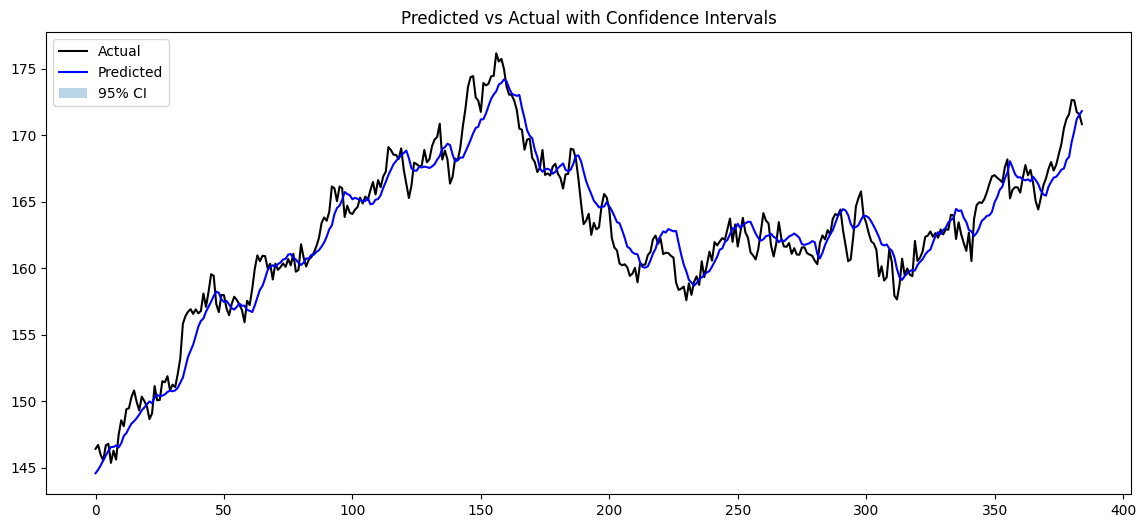

T-test LSTM vs GRU: 6.600975319661175e-13
T-test LSTM vs CNN: 1.5370434063948186e-12
T-test GRU vs CNN: 9.076344480874958e-23


In [ ]:
# Plot predictions with confidence intervals
plt.figure(figsize=(14,6))
plt.plot(y_test_actual, label='Actual', color='black')
plt.plot(ensemble_mean, label='Predicted', color='blue')
plt.fill_between(range(len(ensemble_mean)), ensemble_low, ensemble_high, alpha=0.3, label='95% CI')
plt.legend()
plt.title("Predicted vs Actual with Confidence Intervals")
plt.show()

# T-tests between models
print("T-test LSTM vs GRU:", ttest_rel(pred_lstm_actual, pred_gru_actual).pvalue)
print("T-test LSTM vs CNN:", ttest_rel(pred_lstm_actual, pred_cnn_actual).pvalue)
print("T-test GRU vs CNN:", ttest_rel(pred_gru_actual, pred_cnn_actual).pvalue)

  0%|          | 0/50 [00:00<?, ?it/s]

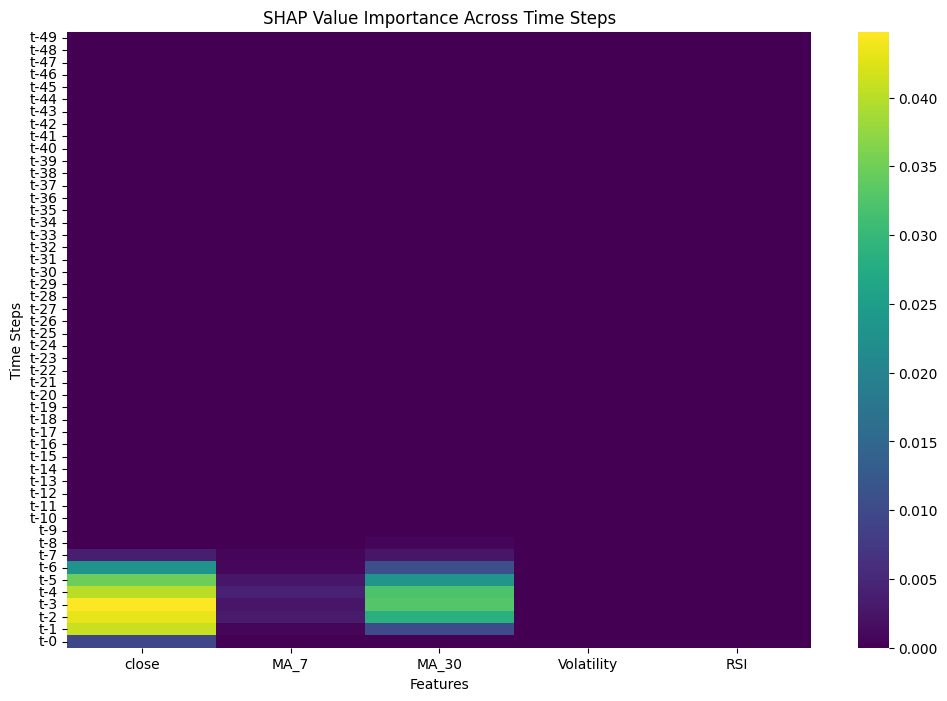

<ipython-input-113-1817938462>:38: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.

/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:726: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



<Figure size 1000x500 with 0 Axes>

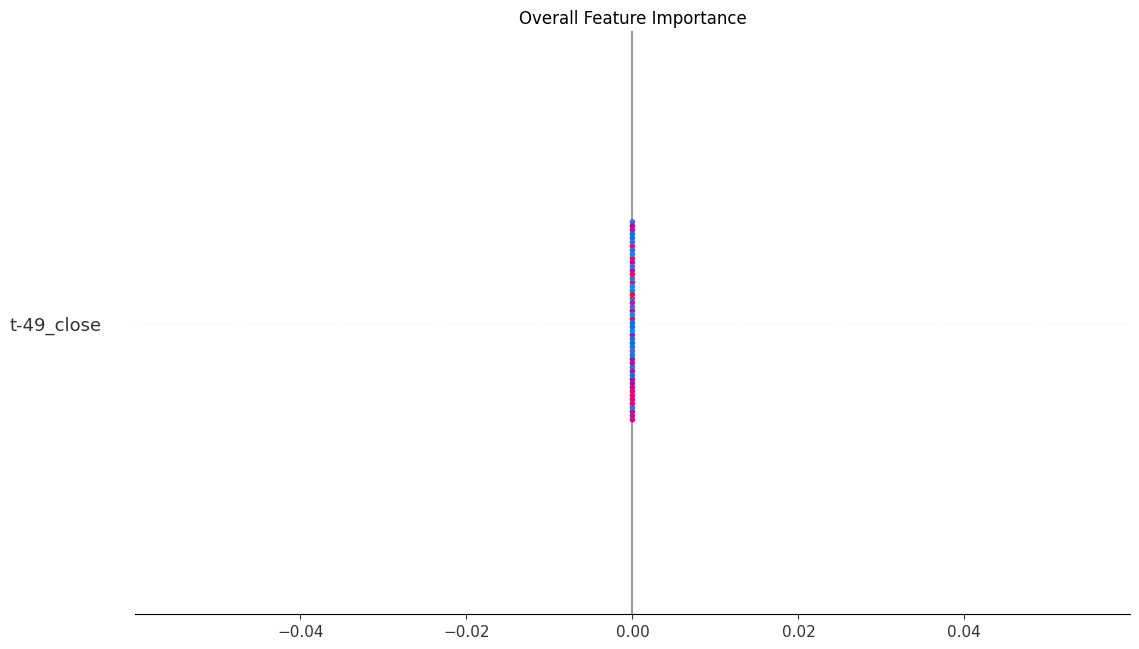

In [ ]:
# 1. Select a representative sample from training data
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# 2. Create explainer - Use KernelExplainer as fallback
def model_predict(X):
    """Reshape data for model prediction"""
    if len(X.shape) == 2:
        X = X.reshape(-1, X_train.shape[1], X_train.shape[2])
    return best_lstm.predict(X, verbose=0)

explainer = shap.KernelExplainer(model_predict, background.mean(axis=0).reshape(1, -1))

# 3. Calculate SHAP values for test samples
X_shap = X_test[:50].reshape(50, -1)  # Flatten time steps and features
shap_values = explainer.shap_values(X_shap)

# 4. Reshape and plot
feature_names = ['close','MA_7','MA_30','Volatility','RSI']
time_step_names = [f't-{i}' for i in range(X_train.shape[1]-1, -1, -1)]

# Aggregate absolute SHAP values across time steps
shap_abs = np.abs(shap_values).mean(axis=0)
shap_abs = shap_abs.reshape(X_train.shape[1], len(feature_names))

# Create heatmap of feature importance over time
plt.figure(figsize=(12, 8))
sns.heatmap(shap_abs,
           xticklabels=feature_names,
           yticklabels=time_step_names,
           cmap='viridis')
plt.title("SHAP Value Importance Across Time Steps")
plt.xlabel("Features")
plt.ylabel("Time Steps")
plt.show()

# Alternative: Bar plot of overall feature importance
plt.figure(figsize=(10, 5))
shap.summary_plot(shap_values, X_shap,
                 feature_names=[f"{t}_{f}" for t in time_step_names for f in feature_names],
                 plot_type='bar',
                 show=False)
plt.title("Overall Feature Importance")
plt.tight_layout()
plt.show()